In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tensorflow.keras.utils import to_categorical

import random
from xgboost import XGBClassifier
import xgboost as xgb

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
dataset = pd.read_csv('C:\\Users\\mznid\\Downloads\\BigML_Dataset_5e8eaf7f4f6bfd2dd0003467.csv')

dataset.head()

,Age,Job,Marital Status,Education,Has credit in default,Avg. credit balance,Has housing loan,Has personal loan,Contact type,Last contact day,Last contact month,Last contact duration (sec),Number of contacts,Days passed,Previous contacts,Outcome previous campaign,Subscribed deposit
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [26]:
dataset = dataset.dropna()

### Separate Labels and Convert to Binary

In [27]:
iddict = {}
for each in list(dataset.iloc[:,16]):
    if each not in iddict.keys():
        iddict[each] = len(iddict)
converted = []
for every in dataset.iloc[:,16]:
    converted.append(iddict[every])
labels = np.array(converted)

### Feature Selection; Drop Labels From Feature Set

In [28]:
df = dataset.iloc[:,[0,1,2,3,4,5,6,7,8,11,12,13,14]]

print(df.columns)

Index(['Age', 'Job', 'Marital Status', 'Education', 'Has credit in default',
       'Avg. credit balance', 'Has housing loan', 'Has personal loan',
       'Contact type', 'Last contact duration (sec)', 'Number of contacts',
       'Days passed', 'Previous contacts'],
      dtype='object')


In [29]:
scaler = MinMaxScaler()
#scaler = StandardScaler()

### Convert 2-Value Categoricals to Binary and Scale Continuous

In [30]:
# Age
df.iloc[:, 0] = scaler.fit_transform(df.iloc[:, [0]])

# Has credit in default
df.iloc[list(df.iloc[:,4] == 'no'), 4] = 0 
df.iloc[list(df.iloc[:,4] == 'yes'), 4] = 1

# Avg credit balance
df.iloc[:, 5] = scaler.fit_transform(df.iloc[:, [5]])

# Has housing
df.iloc[list(df.iloc[:,6] == 'no'), 6] = 0 
df.iloc[list(df.iloc[:,6] == 'yes'), 6] = 1

# Has personal
df.iloc[list(df.iloc[:,7] == 'no'), 7] = 0 
df.iloc[list(df.iloc[:,7] == 'yes'), 7] = 1

# Contact duration
df.iloc[:, 9] = scaler.fit_transform(df.iloc[:, [9]])

# Number contacts
df.iloc[:, 10] = scaler.fit_transform(df.iloc[:, [10]])

# Days passed
df.iloc[:, 11] = scaler.fit_transform(df.iloc[:, [11]])

# Previous contacts
df.iloc[:, 12] = scaler.fit_transform(df.iloc[:, [12]])

### Convert Non-Binary Categoricals to One-Hot

In [31]:
# Job
iddict = {}
for each in list(df.iloc[:,1]):
    if each not in iddict.keys():
        iddict[each] = len(iddict)
converted = []
for every in df.iloc[:,1]:
    converted.append(iddict[every])
Job = to_categorical(converted)

Jobdf = pd.DataFrame(Job)


# Contact type
iddict = {}
for each in list(df.iloc[:,8]):
    if each not in iddict.keys():
        iddict[each] = len(iddict)
converted = []
for every in df.iloc[:,8]:
    converted.append(iddict[every])
ContactType = to_categorical(converted)

ContactTypedf = pd.DataFrame(ContactType)


# Marital Status
iddict = {}
for each in list(df.iloc[:,2]):
    if each not in iddict.keys():
        iddict[each] = len(iddict)
converted = []
for every in df.iloc[:,2]:
    converted.append(iddict[every])
MaritalStatus = to_categorical(converted)

MaritalStatusdf = pd.DataFrame(MaritalStatus)


# Education
iddict = {}
for each in list(df.iloc[:,3]):
    if each not in iddict.keys():
        iddict[each] = len(iddict)
converted = []
for every in df.iloc[:,3]:
    converted.append(iddict[every])
Education = to_categorical(converted)

Educationdf = pd.DataFrame(Education)

### Bring All Normalized Features Together

In [32]:
cleaned = pd.concat([Jobdf, ContactTypedf, MaritalStatusdf, Educationdf, df.iloc[:,list(set(range(0,len(df.columns))) - {1,2,3,8})]], axis = 1)

X = np.array(cleaned)

### Artificially Balance the Dataset

In [33]:
defaultindex = []
for ind,each in enumerate(labels):
    if each == 1:
        defaultindex.append(ind)

selectionpool = defaultindex + list(random.sample(list(set(range(0,len(X))) - set(defaultindex)), len(defaultindex)))

### Train/Test Split

In [34]:
trainindex = random.sample(selectionpool, round(0.8 * len(selectionpool)))
testindex = list( set(selectionpool) - set(trainindex))

train = X[trainindex]
test = X[testindex]
labeltrain = labels[trainindex]
labeltest = labels[testindex]

### Run XGBoost Model

Text(0.5, 1, 'Validation Confusion Matrix')

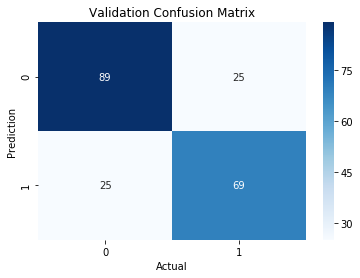

In [40]:
XGBmodel = XGBClassifier()
XGBmodel.fit(train, labeltrain)
preds = XGBmodel.predict(test)


cf = pd.crosstab(preds, labeltest)

sns.heatmap(cf, annot = True, cmap = "Blues", fmt='g')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Validation Confusion Matrix')

In [41]:
print('Validation Accuracy: ' + str(XGBmodel.score(test,labeltest)))

Validation Accuracy: 0.7596153846153846


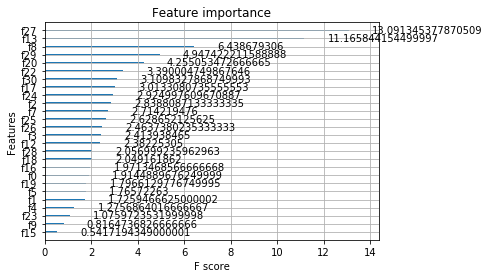

In [42]:
xgb.plot_importance(XGBmodel, importance_type = 'gain')

### Plot a Sample XGBoost Tree

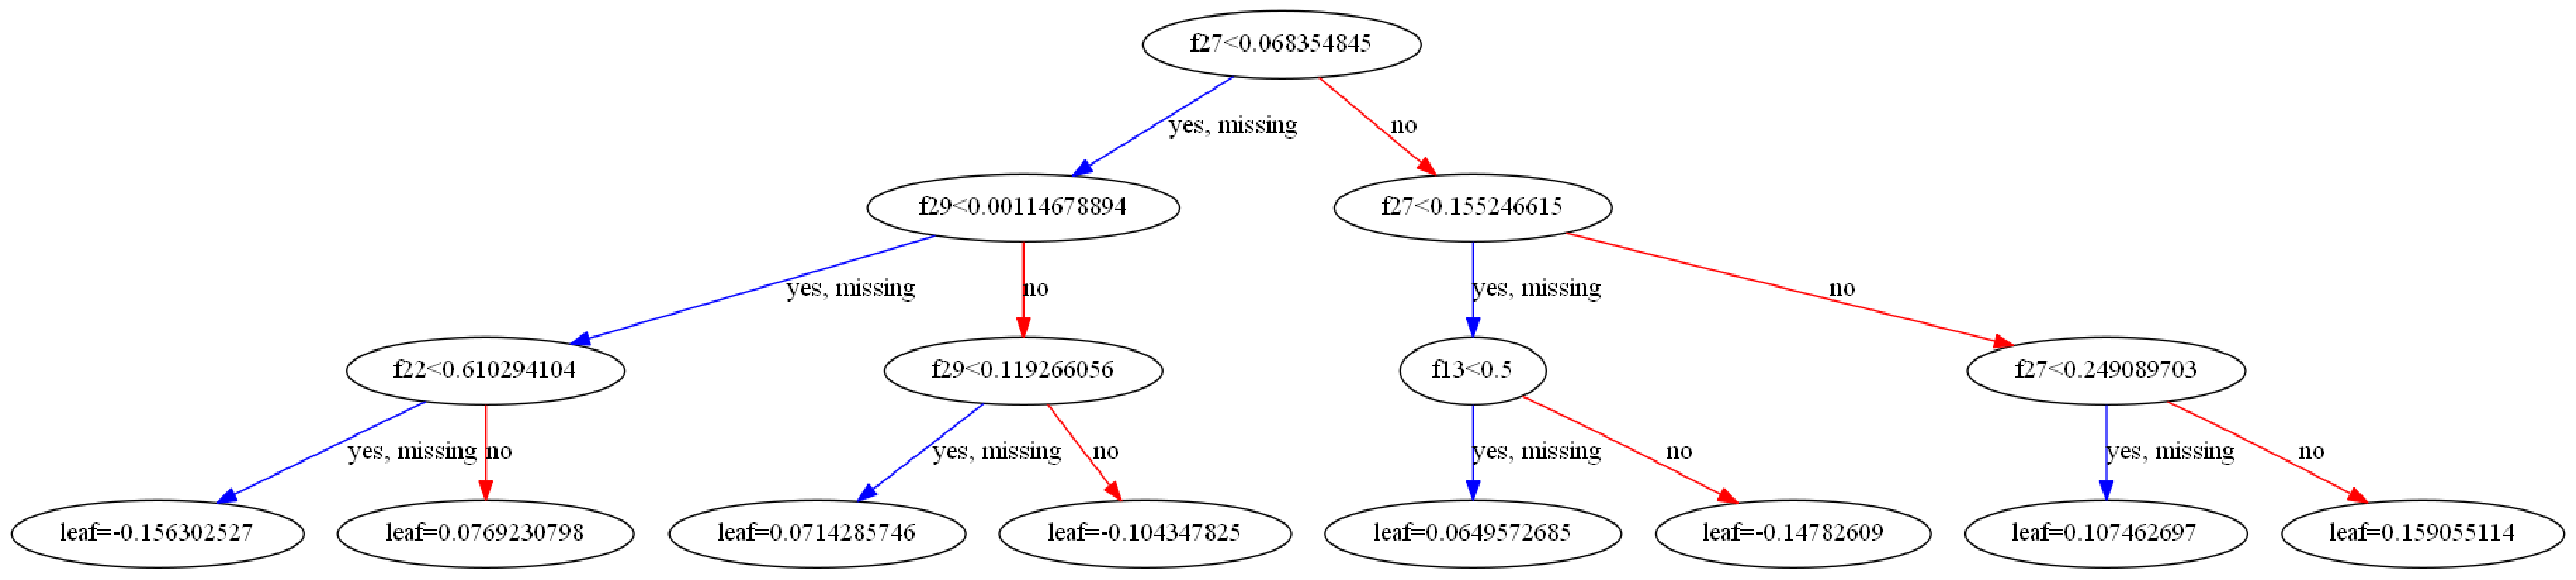

In [45]:
xgb.plot_tree(XGBmodel)
fig = plt.gcf()
fig.set_size_inches(75, 50)